In [1]:
import os
from osgeo import gdal, gdalconst

In [10]:
def add_crs_ndvi(inputfile, referencefile, outputfile):
    input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
    band = input.GetRasterBand(1)
    arr = band.ReadAsArray()

    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    x = reference.RasterXSize
    y = reference.RasterYSize

    driver = gdal.GetDriverByName('GTiff')
    output = driver.Create(outputfile, x, y, 1, gdal.GDT_Int16)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    output.GetRasterBand(1).WriteArray(arr)
    del output


In [9]:
source_dir = "/Users/ava/Desktop/Q/"
inp_file = os.path.join(source_dir, "1_87_20210618T154824_20210624T154855_T35VMF_20210623T094031_7922_2048.png")
ref_file = os.path.join(source_dir, "1_87_20210618T154824_20210624T154855_T35VMF_20210623T094031_7922_2048.tif")
out_file = os.path.join(source_dir, "sample.tif")

add_crs_ndvi(inp_file, ref_file, out_file)

In [5]:
os.path.exists(inp_file)

False

In [6]:
inp_file

'~/Desktop/Q/1_87_20210612T154855_20210618T154824_T35VNF_20210618T094029_6656_5632.png'

In [13]:
def array_to_tiff(arr, referencefile, outputfile):
    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    x = reference.RasterXSize
    y = reference.RasterYSize

    # os.remove(referencefile)

    driver = gdal.GetDriverByName('GTiff')
    output = driver.Create(outputfile, x, y, 1, gdal.GDT_Int16)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    output.GetRasterBand(1).WriteArray(arr)
    del output

In [39]:
# 1_87_20210531T154854_20210606T154824.tif
# /Users/ava/Documents/Work/kz/notebooks/Transit/ARD-EE-RR/Rasters/EE_ARD_MARCH_MAY

dd = "/Users/ava/Documents/Work/kz/notebooks/Transit/ARD-EE-RR/Rasters/EE_ARD_MARCH_MAY"
df = os.path.join(dd, "1_87_20210507T154852_20210513T154813_T35VMF_20210514T094031_5874_4608.tif")
of = os.path.join(dd, "tile.tif")

# add_crs_ndvi(df, df, of)

In [84]:

import numpy as np
def create_constant_raster(r_in, r_out):
    reference = gdal.Open(r_in, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    x = reference.RasterXSize
    y = reference.RasterYSize

    band = reference.GetRasterBand(1)
    arr = band.ReadAsArray()
    zarr = np.full_like(arr, -32678)

    driver = gdal.GetDriverByName('GTiff')
    output = driver.Create(r_out, x, y, 1, gdal.GDT_Int16)
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)
    output.GetRasterBand(1).WriteArray(zarr)
    del output

In [40]:
# Get parcels from tile
from geotiff import GeoTiff

source_tile = np.array(GeoTiff(df).read())[:, :, 4]
source_parcel_tile = np.array(GeoTiff(of).read())

In [32]:
import time

s = time.time()
pids = np.unique(source_parcel_tile)
print("Time elapsed: {}s".format(round(time.time()-s, 2)))

Time elapsed: 0.01s


In [3]:
# Get parcels from tile
import shutil
import time

mask_parcels = lambda geom, r_out: "gdal_rasterize -a PARCEL_FOR {} {}".format(geom, r_out)
constant_raster = lambda r_in, r_out: "gdal_create -if {} {}".format(r_in, r_out)

dd = "/Users/ava/Documents/Work/kz/notebooks/Transit/ARD-EE-RR/Rasters/EE_ARD_MARCH_MAY"

tile_source_dir = os.path.join(dd, "train_test")
tile_target_dir = os.path.join(dd, "train_test_geom")

parcel_shp = os.path.join(dd, "borders/EE32635.shp")

# if os.path.exists(tile_target_dir):
#     shutil.rmtree(tile_target_dir)
# os.mkdir(tile_target_dir)

st = time.time()

for tile in os.listdir(tile_source_dir):
    if tile.endswith("tif"):
        tilepath = os.path.join(tile_source_dir, tile)
        r_out = os.path.join(tile_target_dir, tile)
        create_constant_raster(tilepath, r_out)
        os.system(mask_parcels(parcel_shp, r_out))
    
en = time.time()

print("Time elapsed: {}s".format(round(en-st, 2)))

In [66]:
import tensorflow as tf

# Compare ndvi-sndvi MAE
def polygon_mae(source_ndvi, source_sndvi, source_parcel, pid):
    parcel = np.where(source_parcel == pid, 1, 0)
    ndvi = np.where((parcel != 0), source_ndvi, 1)
    sndvi = np.where((parcel != 0), source_sndvi, 1)
    return tf.reduce_mean(tf.abs(ndvi-sndvi)).numpy()
    

In [ ]:
# polygon_mae(source_tile, source_tile, source_parcel_tile, 1000)
from multiprocessing import Pool

st = time.time()
with Pool(5) as p:
    print(p.starmap(polygon_mae, [(source_tile, source_tile, source_parcel_tile, pid) for pid in [pids[0]]]))
en = time.time()

print("Time elapsed: {}s".format(round(en-st, 2)))

In [ ]:
st = time.time()
for pid in pids:
    print("MAE = ", polygon_mae(source_tile, source_tile, source_parcel_tile, pid))
en = time.time()

print("Time elapsed: {}s".format(round(en-st, 2)))

In [56]:
import random

pid = random.choice(pids)

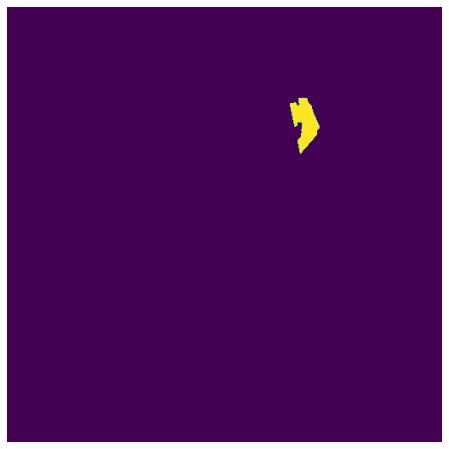

In [57]:
import matplotlib.pyplot as plt

parcel_eg = np.where(source_parcel_tile == pid, 1, 0)
plt.figure(figsize=(10, 8))
plt.imshow(parcel_eg)
plt.axis('off')
plt.show()

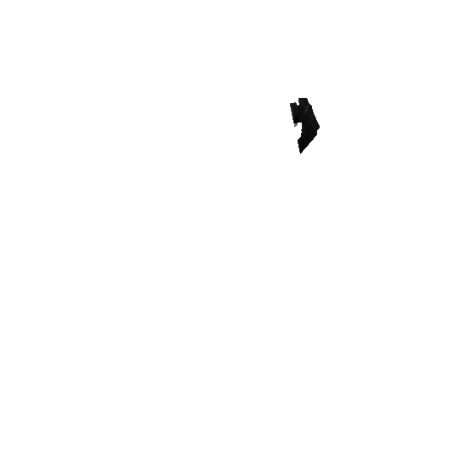

In [58]:
parcel_ndvi = np.where((parcel_eg != 0), source_tile, 1)
plt.figure(figsize=(10, 8))
plt.imshow(parcel_ndvi, cmap="gray")
plt.axis('off')
plt.show()

In [59]:
parcel_ndvi = [v for v in parcel_ndvi.flatten() if v != 1.]
np.mean(parcel_ndvi)

0.18837687

0.19007811

In [55]:
# np.mean(np.where((parcel_eg != 0), source_tile, 1), where=1.)